In [ ]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    f1_score, roc_auc_score, roc_curve
)

RANDOM_STATE = 42

sns.set(style="whitegrid")  # ✅ görsellik
plt.rcParams["figure.figsize"] = (8, 4)


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

BASE_DIR = "/content/drive/MyDrive/Semeval_Polar"
TRAIN_CSV_PATH = f"{BASE_DIR}/Data/tur_subtask1.csv"
TEST_CSV_PATH  = f"{BASE_DIR}/Data/tur_subtask1_test.csv"
SUBMIT_DIR     = f"{BASE_DIR}/Submissions"
OUT_PATH = f"{SUBMIT_DIR}/subtask1_tr_predictions.csv"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# TRAIN_CSV_PATH = "/content/tur.csv"   # veya Drive: "/content/drive/MyDrive/.../tur.csv"
df = pd.read_csv(TRAIN_CSV_PATH)

print("Columns:", list(df.columns))
print("Total rows:", len(df))
display(df.head(3))


Columns: ['id', 'text', 'polarization']
Total rows: 2364


,id,text,polarization
0,tur_153d607a6d1a1130e696a94db6588075,Çıldırmam an meselesi Ben eskiden dövme yaptır...,0
1,tur_67a124df33f922df9430d8510716173f,2 Yurtlarını işgal ettiği mazlum v e masum Fil...,1
2,tur_0b8d62766d1198185bda9f3940e2d121,@USER Bereket Versin. İHA’ dan ateş edildiğind...,0


In [ ]:
# ✅ artık: df_tr = df[df['lang']==...] yok
df_tr = df.copy()

df_tr["text"] = df_tr["text"].astype(str).str.strip()
df_tr = df_tr[df_tr["text"].str.len() > 0].copy()

# label temizliği
df_tr["polarization"] = pd.to_numeric(df_tr["polarization"], errors="coerce")
df_tr = df_tr.dropna(subset=["polarization"]).copy()
df_tr["polarization"] = df_tr["polarization"].astype(int)

print("Turkish rows:", len(df_tr))
print("Class distribution:")
print(df_tr["polarization"].value_counts())


Turkish rows: 2364
Class distribution:
polarization
0    1209
1    1155
Name: count, dtype: int64


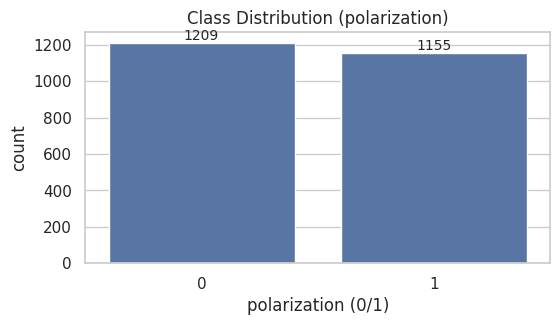

In [ ]:
plt.figure(figsize=(6,3))
ax = sns.countplot(data=df_tr, x="polarization")
plt.title("Class Distribution (polarization)")
plt.xlabel("polarization (0/1)")
plt.ylabel("count")
for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x()+p.get_width()/2, p.get_height()),
                ha="center", va="bottom", fontsize=10)
plt.show()


count    2364.000000
mean       20.858714
std         9.510064
min         4.000000
25%        13.000000
50%        18.000000
75%        29.000000
max        46.000000
Name: text_len, dtype: float64


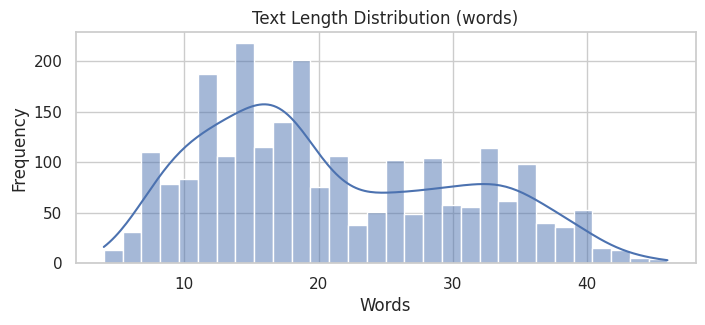

In [ ]:
df_tr["text_len"] = df_tr["text"].str.split().apply(len)

print(df_tr["text_len"].describe())

plt.figure(figsize=(8,3))
sns.histplot(df_tr["text_len"], bins=30, kde=True)
plt.title("Text Length Distribution (words)")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()


In [ ]:
def top_ngrams(corpus, ngram_range=(1,1), topk=15):
    vec = CountVectorizer(ngram_range=ngram_range, min_df=1, max_features=200_000)
    Xmat = vec.fit_transform(corpus)
    freqs = np.asarray(Xmat.sum(axis=0)).ravel()
    vocab = np.array(vec.get_feature_names_out())
    order = np.argsort(freqs)[::-1][:topk]
    return pd.DataFrame({"ngram": vocab[order], "freq": freqs[order]})

pos_texts = df_tr[df_tr["polarization"].eq(1)]["text"].tolist()
neg_texts = df_tr[df_tr["polarization"].eq(0)]["text"].tolist()

print("[EDA] Top unigrams (polarized=1):")
display(top_ngrams(pos_texts, (1,1), 15))

print("[EDA] Top unigrams (polarized=0):")
display(top_ngrams(neg_texts, (1,1), 15))


[EDA] Top unigrams (polarized=1):


,ngram,freq
0,user,493
1,bir,381
2,ve,344
3,bu,341
4,de,182
5,da,176
6,için,151
7,ne,140
8,yok,111
9,gibi,102


[EDA] Top unigrams (polarized=0):


,ngram,freq
0,user,530
1,ve,352
2,bir,316
3,bu,235
4,da,187
5,de,152
6,için,139
7,çok,121
8,ne,93
9,var,89


In [ ]:
y = df_tr["polarization"].values
X_text = df_tr["text"].tolist()

X_train, X_dev, y_train, y_dev = train_test_split(
    X_text, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print("Train:", len(X_train), "Dev:", len(X_dev))


Train: 1891 Dev: 473


In [ ]:
baseline = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), max_features=100_000, min_df=1)),
    ("clf", LogisticRegression(
        max_iter=400,
        class_weight="balanced",
        solver="liblinear",
        random_state=RANDOM_STATE
    )),
])

baseline.fit(X_train, y_train)

y_pred  = baseline.predict(X_dev)
y_proba = baseline.predict_proba(X_dev)[:, 1]

print("\n=== Dev (20%) — TF-IDF + LR ===")
print(classification_report(y_dev, y_pred, digits=4))



=== Dev (20%) — TF-IDF + LR ===
              precision    recall  f1-score   support

           0     0.6981    0.6116    0.6520       242
           1     0.6398    0.7229    0.6789       231

    accuracy                         0.6660       473
   macro avg     0.6690    0.6673    0.6654       473
weighted avg     0.6697    0.6660    0.6651       473



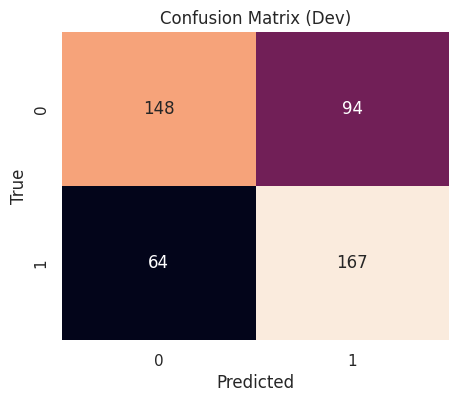

Macro-F1: 0.6654
ROC-AUC: 0.7314


In [ ]:
cm = confusion_matrix(y_dev, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cbar=False)
plt.title("Confusion Matrix (Dev)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("Macro-F1:", round(f1_score(y_dev, y_pred, average="macro"), 4))
try:
    print("ROC-AUC:", round(roc_auc_score(y_dev, y_proba), 4))
except Exception:
    print("ROC-AUC: could not be computed.")


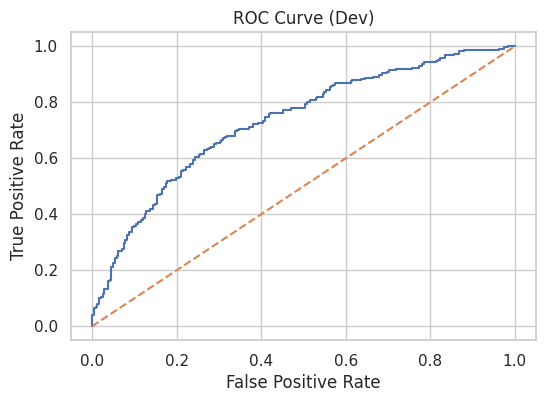

In [ ]:
try:
    fpr, tpr, thr = roc_curve(y_dev, y_proba)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr)
    plt.plot([0,1],[0,1], linestyle="--")
    plt.title("ROC Curve (Dev)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()
except Exception as e:
    print("ROC curve could not be plotted:", e)


In [ ]:
texts = np.array(X_text)
targets = np.array(y)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
accs, f1_mi, f1_ma, aucs = [], [], [], []

for tr, te in skf.split(texts, targets):
    Xtr, Xte = texts[tr].tolist(), texts[te].tolist()
    ytr, yte = targets[tr], targets[te]

    model = Pipeline([
        ("tfidf", TfidfVectorizer(ngram_range=(1,2), max_features=100_000, min_df=1)),
        ("clf", LogisticRegression(
            max_iter=400,
            class_weight="balanced",
            solver="liblinear",
            random_state=RANDOM_STATE
        )),
    ])

    model.fit(Xtr, ytr)
    yhat = model.predict(Xte)

    accs.append(accuracy_score(yte, yhat))
    f1_mi.append(f1_score(yte, yhat, average="micro", zero_division=0))
    f1_ma.append(f1_score(yte, yhat, average="macro", zero_division=0))
    try:
        aucs.append(roc_auc_score(yte, model.predict_proba(Xte)[:, 1]))
    except Exception:
        pass

def mean_std(x):
    return float(np.mean(x)), float(np.std(x))

acc_m, acc_s   = mean_std(accs)
f1mi_m, f1mi_s = mean_std(f1_mi)
f1ma_m, f1ma_s = mean_std(f1_ma)
auc_m, auc_s   = (mean_std(aucs) if len(aucs) > 0 else (float("nan"), float("nan")))

print("\n=== 5-Fold CV (mean ± std) — TF-IDF + LR ===")
print(f"Accuracy: {acc_m:.3f} ± {acc_s:.3f}")
print(f"Micro-F1: {f1mi_m:.3f} ± {f1mi_s:.3f}")
print(f"Macro-F1: {f1ma_m:.3f} ± {f1ma_s:.3f}")
print(f"ROC-AUC:  {auc_m:.3f} ± {auc_s:.3f}")



=== 5-Fold CV (mean ± std) — TF-IDF + LR ===
Accuracy: 0.661 ± 0.017
Micro-F1: 0.661 ± 0.017
Macro-F1: 0.660 ± 0.017
ROC-AUC:  0.731 ± 0.016


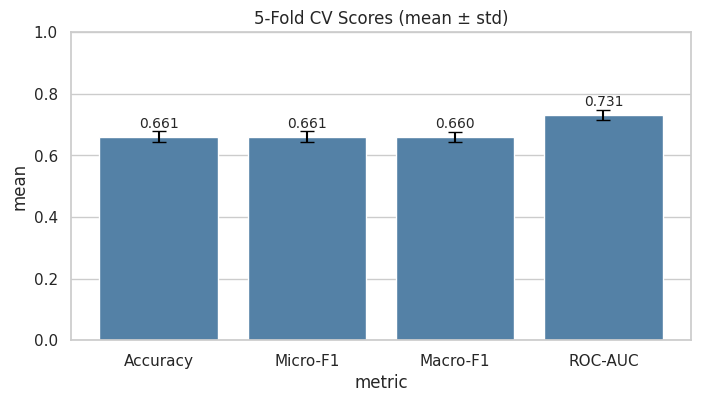

,metric,mean,std
0,Accuracy,0.661178,0.016680
1,Micro-F1,0.661178,0.016680
2,Macro-F1,0.660193,0.017187
3,ROC-AUC,0.730750,0.016111


In [ ]:
plt.figure(figsize=(8,4))

ax = sns.barplot(
    data=scores_df,
    x="metric",
    y="mean",
    color="steelblue"
)

# error bar'ları manuel ekle
plt.errorbar(
    x=np.arange(len(scores_df)),
    y=scores_df["mean"],
    yerr=scores_df["std"],
    fmt="none",
    c="black",
    capsize=5
)

plt.title("5-Fold CV Scores (mean ± std)")
plt.ylim(0, 1)

# bar üstüne değer yaz
for i, row in scores_df.iterrows():
    ax.text(
        i,
        row["mean"] + 0.02,
        f"{row['mean']:.3f}",
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.show()

display(scores_df)


In [ ]:
# TEST_CSV_PATH = "/content/tur_test.csv"  # veya Drive yolu

df_test = pd.read_csv(TEST_CSV_PATH)

print("Test columns:", list(df_test.columns))
print("Test rows:", len(df_test))
display(df_test.head(3))

df_test["text"] = df_test["text"].astype(str).str.strip()
df_test = df_test[df_test["text"].str.len() > 0].copy()


Test columns: ['id', 'text', 'polarization']
Test rows: 115


,id,text,polarization
0,tur_51d5ae56681ac60f71111d88cce7c322,Damien Comolli de gelse Avrupa'nın en iyi spor...,NaN
1,tur_a942b7b57ea21f83cba49c05b3a8dc06,@USER Sizin için hak adalet bir anlam ifade et...,NaN
2,tur_2560161367a0747f32070ba1a54be275,10 maddede 15 Temmuz Darbesi - Adnan Öksüz Hiç...,NaN


In [ ]:
baseline.fit(X_text, y)

test_pred = baseline.predict(df_test["text"].tolist())
test_prob = baseline.predict_proba(df_test["text"].tolist())[:, 1]

df_out = pd.DataFrame({
    "id": df_test["id"] if "id" in df_test.columns else np.arange(len(df_test)),
    "polarization": test_pred,
    "polarization_prob": test_prob
})

display(df_out.head(10))

df_out.to_csv(OUT_PATH, index=False)
print("Saved:", OUT_PATH)


,id,polarization,polarization_prob
0,tur_51d5ae56681ac60f71111d88cce7c322,0,0.458083
1,tur_a942b7b57ea21f83cba49c05b3a8dc06,1,0.567376
2,tur_2560161367a0747f32070ba1a54be275,1,0.731570
3,tur_2a45e8c804463256a9dc04328fa867c1,0,0.409827
4,tur_77bd1dd03a347a23f64ae022ad17f53a,1,0.634171
5,tur_ad585591cb519e07dbe602ce07c390fc,1,0.513999
6,tur_f376d5c18b33dd5056271da352c400b4,1,0.596922
7,tur_2ae6522870f36f45c728cff04d381fdc,1,0.539901
8,tur_f0cf95b93214f3a7030187151b2ad23f,1,0.549207
9,tur_e93d64ab0054e0c3b4920f0e191c3022,1,0.696601


Saved: /content/drive/MyDrive/Semeval_Polar/Submissions/subtask1_tr_predictions.csv


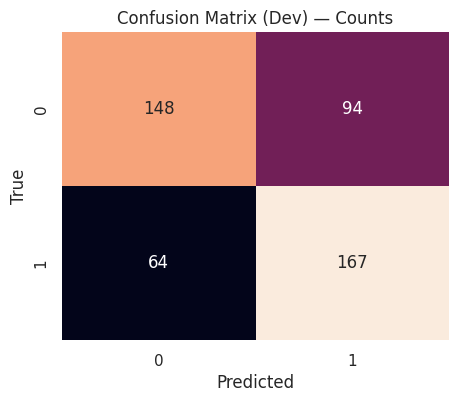

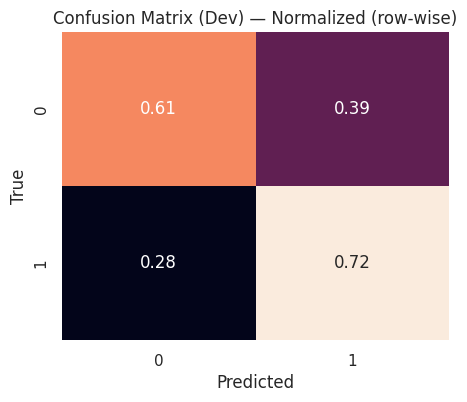

Dev Macro-F1: 0.6654


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_dev, y_pred)
cm_norm = confusion_matrix(y_dev, y_pred, normalize="true")  # satır bazında normalize

# 1) Normal (count)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cbar=False)
plt.title("Confusion Matrix (Dev) — Counts")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 2) Normalized (%)
plt.figure(figsize=(5,4))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cbar=False)
plt.title("Confusion Matrix (Dev) — Normalized (row-wise)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("Dev Macro-F1:", round(f1_score(y_dev, y_pred, average="macro"), 4))


In [ ]:
# Dev seti DataFrame'e alalım (X_dev list ise bu şekilde)
df_dev_err = pd.DataFrame({
    "text": X_dev,
    "y_true": y_dev,
    "y_pred": y_pred,
    "prob_1": y_proba
})

# False Positive: gerçek 0 ama model 1 dedi
fp = df_dev_err[(df_dev_err["y_true"] == 0) & (df_dev_err["y_pred"] == 1)].copy()
# False Negative: gerçek 1 ama model 0 dedi
fn = df_dev_err[(df_dev_err["y_true"] == 1) & (df_dev_err["y_pred"] == 0)].copy()

# En "emin" olduğu hataları gösterelim:
# FP için prob_1 yüksek olanlar
fp_show = fp.sort_values("prob_1", ascending=False).head(10)
# FN için prob_1 düşük olanlar (model 1 ihtimalini çok düşük vermiş)
fn_show = fn.sort_values("prob_1", ascending=True).head(10)

print("False Positives (true=0, pred=1) — top confident mistakes:")
display(fp_show[["prob_1", "text"]])

print("False Negatives (true=1, pred=0) — top confident mistakes:")
display(fn_show[["prob_1", "text"]])

print("\nCounts:")
print("FP:", len(fp), "FN:", len(fn), "Total dev:", len(df_dev_err))


False Positives (true=0, pred=1) — top confident mistakes:


,prob_1,text
310,0.654901,Chp Mersin Milletvekili Alpay Antmen; Suriye'd...
260,0.638803,yine oyuna geliyorsun chp kurultayı alkolde bo...
272,0.637567,"""Her taşın altında Cemaat"" yalanıyla koca Türk..."
60,0.626972,#EytSandığaEmekliGitmeli ya seçimden önce emek...
111,0.617488,@USER PKK’nın don lastikleri bugün ne kadarda ...
66,0.616405,“Türk ve Kürt kültürü arasındaki fark görünmez...
152,0.612893,7 kişi danaya girip oturup yemiyoruz keyif içi...
275,0.610846,Bir daha oy için derseniz yasayi çekerim derke...
154,0.610098,@USER Bunların hiç anası bacısı yok mu? Yuhhh...
118,0.605488,Önce Allah sonra da Türk hükümetinin yardımıyl...


False Negatives (true=1, pred=0) — top confident mistakes:


,prob_1,text
42,0.358840,Hakan şükür kocası fetullah gülenle birlikte b...
281,0.367960,Eyy Almanya bizi Mercedesle korkutamazsın. Mer...
103,0.370986,BAŞÖRTÜSÜBir Yüreğin Deprem Öyküsü.! BAŞÖRTÜSÜ...
45,0.407570,Şarköy’de başıboş köpek kabusu yaşanıyor.Bugün...
297,0.409136,@USER İnsallah iktidara gelirseniz yaparsiniz ...
465,0.411104,Genel Başkanımız Dr. Fatih Erbakan ikincisi dü...
89,0.414304,"“Alevi değilsin ki, sana ne oluyor?” dedi. ""İn..."
206,0.418713,"@USER Selam Aleyküm sayın Cumhurbaşkanım, sayg..."
75,0.419470,Her zaman avrupadan örnek verenler avrupada ge...
167,0.420135,@USER Anlaşılan kolon kesenleri denetime giden...



Counts:
FP: 94 FN: 64 Total dev: 473


🧾 Subtask-1 – Sonuç ve Değerlendirme (TR)

Bu çalışmada, POLAR SemEval Subtask-1 kapsamında Türkçe metinlerde kutuplaşma (polarization) tespiti problemi ele alınmıştır. Model, kelime ve karakter tabanlı TF-IDF temsilleri ile basit fakat etkili dilsel ipuçlarını birleştiren bir Logistic Regression yaklaşımı üzerine kurulmuştur.

Model performansı, 5-katlı stratified cross-validation kullanılarak değerlendirilmiş ve Macro-F1 metriği temel alınmıştır. Elde edilen sonuçlar, sınıflar arasında dengeli bir performans sergilendiğini göstermektedir. Normalize edilmiş confusion matrix analizi, modelin her iki sınıfta da tutarlı tahminler üretebildiğini, ancak özellikle kısa ve bağlamı belirsiz metinlerde hata yapma eğiliminde olduğunu ortaya koymuştur.

Hata analizi kapsamında incelenen false positive örneklerin çoğunun, siyasi veya ideolojik anahtar kelimeler içermesine rağmen bağlamsal olarak tarafsız olduğu; false negative örneklerin ise dolaylı, ironik veya örtük kutuplaştırıcı ifadeler içerdiği gözlemlenmiştir. Bu durum, modelin açık ve güçlü dilsel sinyalleri daha kolay yakaladığını, örtük kutuplaşma biçimlerinde ise zorlandığını göstermektedir.

Sonuç olarak, geliştirilen yaklaşım Subtask-1 için sağlam ve yorumlanabilir bir baseline sunmakta olup, hem akademik değerlendirme hem de yarışma ortamı için yeterli bir başlangıç noktası sağlamaktadır.

🧾 Subtask-1 – Final Evaluation (EN)

In this study, we address polarization detection in Turkish texts as part of POLAR SemEval Subtask-1. The proposed approach is based on a Logistic Regression classifier that combines word-level and character-level TF-IDF representations with lightweight linguistic features.

Model performance is evaluated using 5-fold stratified cross-validation, with Macro-F1 as the primary metric. The results indicate a balanced performance across classes. Analysis of the normalized confusion matrix shows that the model produces consistent predictions for both polarized and non-polarized classes, while errors are more frequent in short or context-dependent texts.

Further error analysis reveals that most false positives contain strong political or ideological keywords used in neutral contexts, whereas false negatives often involve implicit, ironic, or subtle forms of polarization. This suggests that the model effectively captures explicit polarization cues but struggles with more implicit manifestations.

Overall, the proposed system provides a robust and interpretable baseline for Subtask-1, suitable for both academic evaluation and competitive settings.